# Basic Viewer
Ingest the alphas data and try to recreate an image using full sorting.

## Inspect the data.

In [1]:
import numpy as np
import polars as pl

In [2]:
# Define the column names.
column_names = [f"gaussian_{i}_{part}" for i in range(500) for part in ["alpha", "depth", "color_r", "color_g", "color_b"]]
column_names = ["sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g", "background_b"] + column_names

# Define schema.
schema_dict = {name: pl.Float32 for name in column_names}
schema_dict["sample_index"] = pl.Int32
schema = pl.Schema(schema_dict)

In [3]:
data = pl.scan_csv('data/collected_splats.csv', schema=schema)
data.head().collect()

sample_index,out_color_r,out_color_g,out_color_b,background_r,background_g,background_b,gaussian_0_alpha,gaussian_0_depth,gaussian_0_color_r,gaussian_0_color_g,gaussian_0_color_b,gaussian_1_alpha,gaussian_1_depth,gaussian_1_color_r,gaussian_1_color_g,gaussian_1_color_b,gaussian_2_alpha,gaussian_2_depth,gaussian_2_color_r,gaussian_2_color_g,gaussian_2_color_b,gaussian_3_alpha,gaussian_3_depth,gaussian_3_color_r,gaussian_3_color_g,gaussian_3_color_b,gaussian_4_alpha,gaussian_4_depth,gaussian_4_color_r,gaussian_4_color_g,gaussian_4_color_b,gaussian_5_alpha,gaussian_5_depth,gaussian_5_color_r,gaussian_5_color_g,gaussian_5_color_b,…,gaussian_492_color_g,gaussian_492_color_b,gaussian_493_alpha,gaussian_493_depth,gaussian_493_color_r,gaussian_493_color_g,gaussian_493_color_b,gaussian_494_alpha,gaussian_494_depth,gaussian_494_color_r,gaussian_494_color_g,gaussian_494_color_b,gaussian_495_alpha,gaussian_495_depth,gaussian_495_color_r,gaussian_495_color_g,gaussian_495_color_b,gaussian_496_alpha,gaussian_496_depth,gaussian_496_color_r,gaussian_496_color_g,gaussian_496_color_b,gaussian_497_alpha,gaussian_497_depth,gaussian_497_color_r,gaussian_497_color_g,gaussian_497_color_b,gaussian_498_alpha,gaussian_498_depth,gaussian_498_color_r,gaussian_498_color_g,gaussian_498_color_b,gaussian_499_alpha,gaussian_499_depth,gaussian_499_color_r,gaussian_499_color_g,gaussian_499_color_b
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0.884574,0.884441,0.884303,0.0,0.0,0.0,0.004247,1.32014,0.91266,0.64399,0.422232,0.024962,1.57553,0.922838,0.806002,0.553356,0.020815,1.72325,0.774266,0.583302,0.611688,0.014289,2.03644,0.886831,0.766702,0.588314,0.004378,2.49459,0.966481,0.67837,0.458755,0.007983,2.66306,0.809977,0.642796,0.414313,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.884441,0.884303,0.884165,0.0,0.0,0.0,0.00426,1.32014,0.91266,0.64399,0.422232,0.023963,1.57553,0.922838,0.806002,0.553356,0.02086,1.72325,0.774266,0.583302,0.611688,0.010575,2.03644,0.886831,0.766702,0.588314,0.004299,2.49459,0.966481,0.67837,0.458755,0.007885,2.66306,0.809977,0.642796,0.414313,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.884303,0.884165,0.883992,0.0,0.0,0.0,0.004272,1.32014,0.91266,0.64399,0.422232,0.022966,1.57553,0.922838,0.806002,0.553356,0.020904,1.72325,0.774266,0.583302,0.611688,0.007211,2.03644,0.886831,0.766702,0.588314,0.004221,2.49459,0.966481,0.67837,0.458755,0.007787,2.66306,0.809977,0.642796,0.414313,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.884165,0.883992,0.88386,0.0,0.0,0.0,0.004285,1.32014,0.91266,0.64399,0.422232,0.021973,1.57553,0.922838,0.806002,0.553356,0.020947,1.72325,0.774266,0.583302,0.611688,0.00453,2.03644,0.886831,0.766702,0.588314,0.004143,2.49459,0.966481,0.67837,0.458755,0.00769,2.66306,0.809977,0.642796,0.414313,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.883992,0.88386,0.883386,0.0,0.0,0.0,0.004297,1.32014,0.91266,0.64399,0.422232,0.020988,1.57553,0.922838,0.806002,0.553356,0.02099,1.72325,0.774266,0.583302,0.611688,0.004065,2.49459,0.966481,0.67837,0.458755,0.007593,2.66306,0.809977,0.642796,0.414313,0.016962,2.73286,0.903889,0.667611,0.402926,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create image from out color.

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# Select the out color columns.
out_colors_raw = data.select(pl.col("out_color_r", "out_color_g", "out_color_b")).collect().to_numpy()

In [6]:
# Get the width and height of the image.
ground_truth_image = Image.open('data/gt.png')
image_width = ground_truth_image.width
image_height = ground_truth_image.height

## Convert linearized RGB data to w x h x 3 image.

In [7]:
out_colors = out_colors_raw.reshape((image_height, image_width, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0738129..1.66238].


(np.float64(-0.5), np.float64(1263.5), np.float64(831.5), np.float64(-0.5))

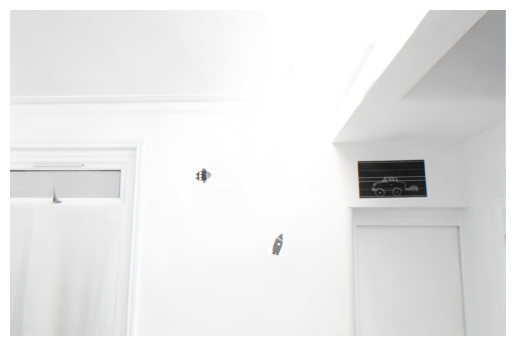

In [8]:
plt.imshow(out_colors)
plt.axis('off')

In [9]:
del out_colors_raw
del ground_truth_image

# Create image by computation.

In [10]:
# Collect all splat columns.
splats_raw = data.select(
    pl.all().exclude("sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g", "background_b"))
splats_raw.head().collect()

gaussian_0_alpha,gaussian_0_depth,gaussian_0_color_r,gaussian_0_color_g,gaussian_0_color_b,gaussian_1_alpha,gaussian_1_depth,gaussian_1_color_r,gaussian_1_color_g,gaussian_1_color_b,gaussian_2_alpha,gaussian_2_depth,gaussian_2_color_r,gaussian_2_color_g,gaussian_2_color_b,gaussian_3_alpha,gaussian_3_depth,gaussian_3_color_r,gaussian_3_color_g,gaussian_3_color_b,gaussian_4_alpha,gaussian_4_depth,gaussian_4_color_r,gaussian_4_color_g,gaussian_4_color_b,gaussian_5_alpha,gaussian_5_depth,gaussian_5_color_r,gaussian_5_color_g,gaussian_5_color_b,gaussian_6_alpha,gaussian_6_depth,gaussian_6_color_r,gaussian_6_color_g,gaussian_6_color_b,gaussian_7_alpha,gaussian_7_depth,…,gaussian_492_color_g,gaussian_492_color_b,gaussian_493_alpha,gaussian_493_depth,gaussian_493_color_r,gaussian_493_color_g,gaussian_493_color_b,gaussian_494_alpha,gaussian_494_depth,gaussian_494_color_r,gaussian_494_color_g,gaussian_494_color_b,gaussian_495_alpha,gaussian_495_depth,gaussian_495_color_r,gaussian_495_color_g,gaussian_495_color_b,gaussian_496_alpha,gaussian_496_depth,gaussian_496_color_r,gaussian_496_color_g,gaussian_496_color_b,gaussian_497_alpha,gaussian_497_depth,gaussian_497_color_r,gaussian_497_color_g,gaussian_497_color_b,gaussian_498_alpha,gaussian_498_depth,gaussian_498_color_r,gaussian_498_color_g,gaussian_498_color_b,gaussian_499_alpha,gaussian_499_depth,gaussian_499_color_r,gaussian_499_color_g,gaussian_499_color_b
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.004247,1.32014,0.91266,0.64399,0.422232,0.024962,1.57553,0.922838,0.806002,0.553356,0.020815,1.72325,0.774266,0.583302,0.611688,0.014289,2.03644,0.886831,0.766702,0.588314,0.004378,2.49459,0.966481,0.67837,0.458755,0.007983,2.66306,0.809977,0.642796,0.414313,0.016979,2.73286,0.903889,0.667611,0.402926,0.06937,2.80312,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.00426,1.32014,0.91266,0.64399,0.422232,0.023963,1.57553,0.922838,0.806002,0.553356,0.02086,1.72325,0.774266,0.583302,0.611688,0.010575,2.03644,0.886831,0.766702,0.588314,0.004299,2.49459,0.966481,0.67837,0.458755,0.007885,2.66306,0.809977,0.642796,0.414313,0.016975,2.73286,0.903889,0.667611,0.402926,0.06921,2.80312,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004272,1.32014,0.91266,0.64399,0.422232,0.022966,1.57553,0.922838,0.806002,0.553356,0.020904,1.72325,0.774266,0.583302,0.611688,0.007211,2.03644,0.886831,0.766702,0.588314,0.004221,2.49459,0.966481,0.67837,0.458755,0.007787,2.66306,0.809977,0.642796,0.414313,0.016971,2.73286,0.903889,0.667611,0.402926,0.069047,2.80312,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004285,1.32014,0.91266,0.64399,0.422232,0.021973,1.57553,0.922838,0.806002,0.553356,0.020947,1.72325,0.774266,0.583302,0.611688,0.00453,2.03644,0.886831,0.766702,0.588314,0.004143,2.49459,0.966481,0.67837,0.458755,0.00769,2.66306,0.809977,0.642796,0.414313,0.016966,2.73286,0.903889,0.667611,0.402926,0.068882,2.80312,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004297,1.32014,0.91266,0.64399,0.422232,0.020988,1.57553,0.922838,0.806002,0.553356,0.02099,1.72325,0.774266,0.583302,0.611688,0.004065,2.49459,0.966481,0.67837,0.458755,0.007593,2.66306,0.809977,0.642796,0.414313,0.016962,2.73286,0.903889,0.667611,0.402926,0.068715,2.80312,0.896675,0.636188,0.416635,0.101144,3.09143,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Single pixel computation.

In [11]:
# Get the first pixel.
pixel_splats_raw = splats_raw.select(pl.all()).head(1).collect().to_numpy()
pixel_splats_reshaped = pixel_splats_raw.reshape((pixel_splats_raw.shape[1] // 5, 5))

### Compute the pixel color.
- Transmittance starts at 1 and for each splat it is multiplied by 1 - the alpha value of the previous splat.
- Pixel color starts with the first splat's color multiplied by its alpha value.

In [12]:
transmittance = 1.0
pixel_color = pixel_splats_reshaped[0][0] * pixel_splats_reshaped[0][2:]

In [13]:
for i in range(1, len(pixel_splats_reshaped)):
    transmittance *= 1 - pixel_splats_reshaped[i - 1][0]
    pixel_color += pixel_splats_reshaped[i][0] * pixel_splats_reshaped[i][2:] * transmittance


### Display the computed pixel color.

(np.float64(-0.5), np.float64(0.5), np.float64(0.5), np.float64(-0.5))

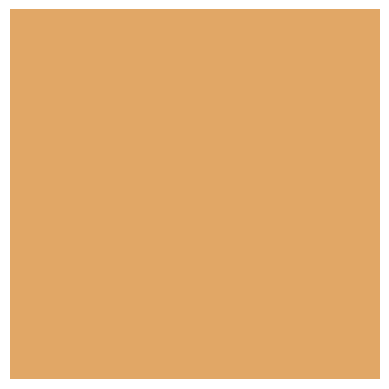

In [14]:
single_pixel_image = np.array([[pixel_color]])
plt.imshow(single_pixel_image)
plt.axis('off')

### Compare the computed pixel color with the original output value.

In [15]:
# Get the original pixel color.
original_pixel_color = data.select(pl.col("out_color_r", "out_color_g", "out_color_b")).head(1).collect().to_numpy()
print(original_pixel_color)
print(pixel_color)

[[0.884574 0.884441 0.884303]]
[0.88457423 0.6586658  0.40202853]


In [16]:
# Compute the distance.
np.linalg.norm(pixel_color - original_pixel_color)

np.float32(0.53250647)

In [17]:
# Compute the percent error for each channel.
channel_error = np.abs(original_pixel_color - pixel_color) / original_pixel_color * 100
channel_error

array([[2.6952926e-05, 2.5527451e+01, 5.4537243e+01]], dtype=float32)

In [18]:
# Compute the mean percent error.
np.mean(channel_error)

np.float32(26.68824)

## Full image computation


In [19]:
from tqdm.contrib import itertools

In [20]:
FACTOR = 3

In [21]:
# Collect all splat columns.
splats_raw_collected = splats_raw.collect().to_numpy()

In [22]:
# Reshape the splats data into h x w x splats x alpha, depth, color.
splats_reshaped = splats_raw_collected.reshape((image_height, image_width, splats_raw_collected.shape[1] // 5, 5))

In [23]:
# Create a working image size for testing.
WORKING_HEIGHT = image_height // FACTOR
WORKING_WIDTH = image_width // FACTOR

In [24]:
# Compute the image.
transmittances = np.ones((WORKING_HEIGHT, WORKING_WIDTH))
pixel_colors = np.zeros((WORKING_HEIGHT, WORKING_WIDTH, 3))

# Do initial color.
for i, j in itertools.product(range(WORKING_HEIGHT), range(WORKING_WIDTH)):
    pixel_colors[i, j] = splats_reshaped[i, j][0][0] * splats_reshaped[i, j][0][2:]

  0%|          | 0/116617 [00:00<?, ?it/s]

In [25]:
# Do the other splats.
for i, j in itertools.product(range(WORKING_HEIGHT), range(WORKING_WIDTH)):
    for k in range(1, len(splats_reshaped[i, j])):
        transmittances[i, j] *= 1 - splats_reshaped[i, j][k - 1][0]
        pixel_colors[i, j] += splats_reshaped[i, j][k][0] * splats_reshaped[i, j][k][2:] * transmittances[i, j]

  0%|          | 0/116617 [00:00<?, ?it/s]

### Display the computed image.

(np.float64(-0.5), np.float64(420.5), np.float64(276.5), np.float64(-0.5))

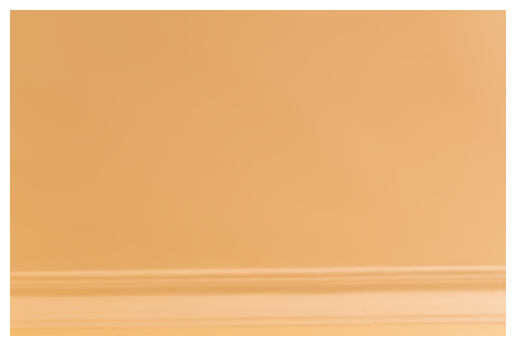

In [26]:
plt.imshow(pixel_colors)
plt.axis('off')

### Compute metrics compared to original image.


In [27]:
# Compute channel percent error.
absolute_difference = np.abs(pixel_colors - out_colors)
percent_error = absolute_difference / out_colors * 100


ValueError: operands could not be broadcast together with shapes (277,421,3) (832,1264,3) 

In [ ]:
from matplotlib.colors import LogNorm

In [80]:
# Mean percent error per pixel as a heat map
per_pixel_error = np.mean(percent_error, axis=2)

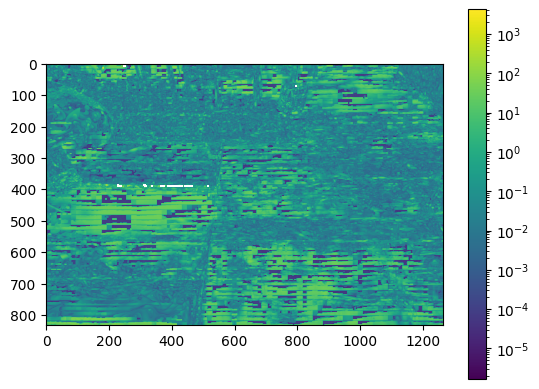

In [83]:
minimum_error = np.nanmin(per_pixel_error)
maximum_error = np.nanmax(per_pixel_error[np.isfinite(per_pixel_error)])
plt.imshow(per_pixel_error, norm=LogNorm(vmin=minimum_error, vmax=maximum_error))
plt.colorbar()